# **Introduction**

In [1]:
import polars as pl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import compute_class_weight
from collections import Counter
from tensorflow.keras.callbacks import EarlyStopping
import itertools
import warnings
warnings.filterwarnings(action="ignore")
from zipfile import ZipFile
sns.set_style("darkgrid")
sns.set_palette(palette=["gray", "red", "green"])
import random
import re
from wordcloud import WordCloud
from nltk.corpus import stopwords

In [2]:
#importing req. Lib.
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from mlxtend.plotting import plot_confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report

In [3]:
#load our data set
data = pd.read_csv('/kaggle/input/amazon-fine-food-reviews/Reviews.csv')

In [4]:
data.shape

(568454, 10)

In [5]:
data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [6]:
data.columns

Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text'],
      dtype='object')

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      568454 non-null  int64 
 1   ProductId               568454 non-null  object
 2   UserId                  568454 non-null  object
 3   ProfileName             568428 non-null  object
 4   HelpfulnessNumerator    568454 non-null  int64 
 5   HelpfulnessDenominator  568454 non-null  int64 
 6   Score                   568454 non-null  int64 
 7   Time                    568454 non-null  int64 
 8   Summary                 568427 non-null  object
 9   Text                    568454 non-null  object
dtypes: int64(5), object(5)
memory usage: 43.4+ MB


In [8]:
data.nunique()

Id                        568454
ProductId                  74258
UserId                    256059
ProfileName               218415
HelpfulnessNumerator         231
HelpfulnessDenominator       234
Score                          5
Time                        3168
Summary                   295742
Text                      393579
dtype: int64

In [9]:
data.isnull().sum()

Id                         0
ProductId                  0
UserId                     0
ProfileName               26
HelpfulnessNumerator       0
HelpfulnessDenominator     0
Score                      0
Time                       0
Summary                   27
Text                       0
dtype: int64

Since the number of null values is negligible let us remove the rows with null values.

In [10]:
data.dropna(inplace=True)

In [11]:
data.isnull().sum()

Id                        0
ProductId                 0
UserId                    0
ProfileName               0
HelpfulnessNumerator      0
HelpfulnessDenominator    0
Score                     0
Time                      0
Summary                   0
Text                      0
dtype: int64

In [12]:
data.shape

(568401, 10)

We shall remove the repetative texts which might be result of spam or repeated entry in the database during extraction of the data. We shall also implement regex to remove any tags or website links/urls in the text. We have to feed clean data to the model for better accuracy of results later on.

In [13]:
data = data[["Score", "Text"]]

In [14]:
# Keep only the first occurrence of each duplicate value in the 'Text' column
data = data[data['Text'].duplicated(keep='first') | data['Text'].duplicated(keep=False)]

# Drop duplicates to retain only the first occurrence
data = data.drop_duplicates(subset='Text')

In [15]:
def clean_text(text):
    text = re.sub(r'@[\w_]+', '', text)
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'#\w+', '', text)
    text = re.sub(r'\S*@\S*\s?', '', text)

    return text.strip()

In [16]:
data['Text'] = data['Text'].apply(clean_text)

In [17]:
def get_sentiment(score): 
    if score > 3:
        return "Positive"
    elif score < 3:
        return "Negative"
    else:
        return "Neutral"

In [18]:
data['Sentiment'] = data['Score'].apply(get_sentiment)

data.head()

,Score,Text,Sentiment
3,2,If you are looking for the secret ingredient i...,Negative
10,5,I don't know if it's the cactus or the tequila...,Positive
68,3,"If you're impulsive like me, then $6 is ok. Do...",Neutral
69,5,this was sooooo deliscious but too bad i ate e...,Positive
73,1,Buyer Beware Please! This sweetener is not for...,Negative


# Performing EDA

Sentiment
Negative     8523
Neutral      4373
Positive    45139
dtype: int64


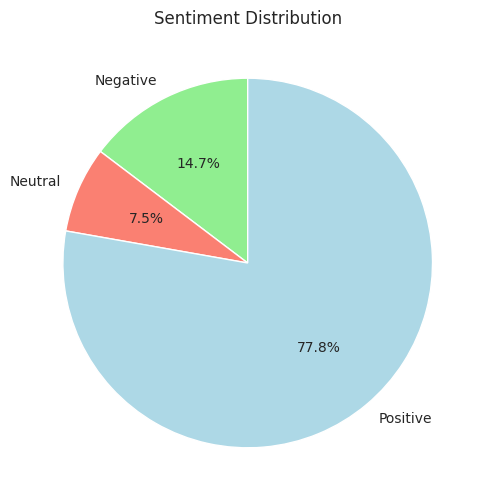

In [19]:
# Group by Sentiment and count the number of occurrences
sentiment_counts = data.groupby('Sentiment').size()

# Display the counts
print(sentiment_counts)

# Create a pie chart
plt.figure(figsize=(6, 6))
sentiment_counts.plot(kind='pie', autopct='%1.1f%%', startangle=90, colors=['lightgreen', 'salmon', 'lightblue'])
plt.title('Sentiment Distribution')
plt.ylabel('')  # Hide y-axis label for better aesthetics
plt.show()

The data is highly imbalanced and contains lots of positive reviews compared to negative reviews. During training, we must send balanced data to the model. To clear this hurdle, I shall randomly choose text from negative and postive categories such that their number count matches with neutral category.

In [20]:
data = data[data['Sentiment'] != 'Neutral']

In [21]:
# Find the minimum number of entries across categories
min_count = data['Sentiment'].value_counts().min()

# Randomly sample rows for each sentiment to balance
data = data.groupby('Sentiment').sample(n=min_count, random_state=42)

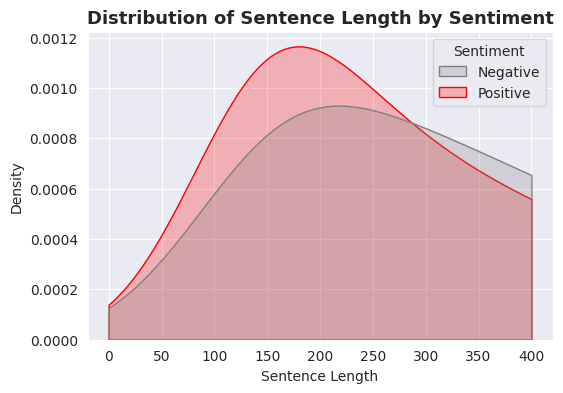

In [22]:
data['length'] = data['Text'].apply(len)

fig = plt.figure(figsize=(6, 4))
sns.kdeplot(data, x="length", shade=True, hue="Sentiment", clip=[0, 400])
plt.title("Distribution of Sentence Length by Sentiment", size=13, weight="bold")
plt.xlabel("Sentence Length")
plt.ylabel("Density")
plt.show()

In [23]:
target = data["Sentiment"]
label_encoder = LabelEncoder()
target = label_encoder.fit_transform(target)

In [24]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [25]:
def clean_text_for_wordcloud(text, stop_words):
    # Remove non-alphabetic characters
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Tokenize and remove stopwords
    words = [word for word in text.lower().split() if word not in stop_words]
    return ' '.join(words)

In [26]:
common_words = {'br'}
all_stop_words = stop_words.union(common_words)

In [27]:
data['Text'] = data['Text'].apply(lambda x: clean_text_for_wordcloud(x, all_stop_words))

In [28]:
positive_text = ' '.join(data[data['Sentiment'] == 'Positive']['Text'])
negative_text = ' '.join(data[data['Sentiment'] == 'Negative']['Text'])

In [29]:
def generate_wordcloud(text, color, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white', colormap=color).generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, size=16, weight='bold')
    plt.show()

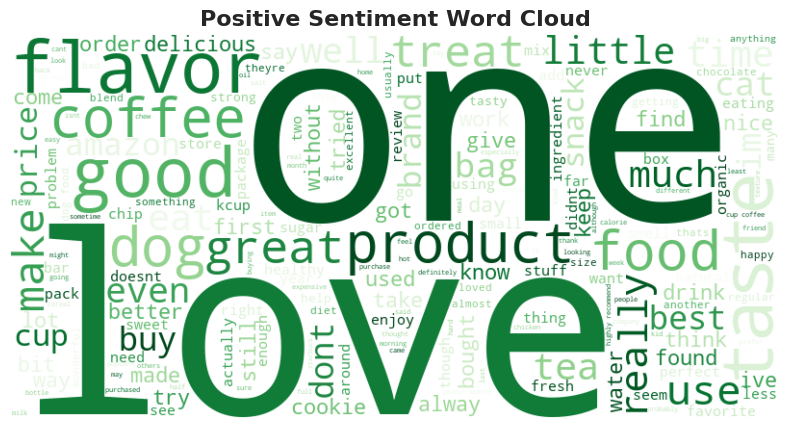

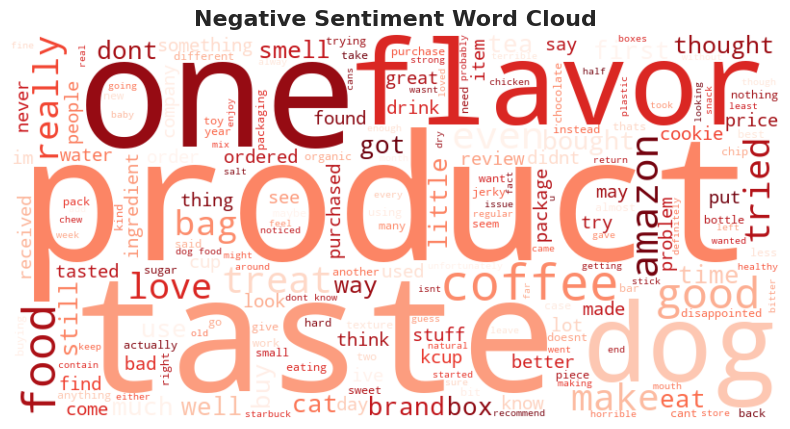

In [30]:
generate_wordcloud(positive_text, 'Greens', 'Positive Sentiment Word Cloud')
generate_wordcloud(negative_text, 'Reds', 'Negative Sentiment Word Cloud')

In [31]:
data=data[['Text','Sentiment']]

# **SVM Solution**

In [32]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.pipeline import make_pipeline
from nltk.corpus import stopwords
import nltk

In [33]:
data['Sentiment'] = data['Sentiment'].map({'Positive': 2, 'Negative': 0, 'Neutral': 1})

In [34]:
data.isnull().sum()

Text         0
Sentiment    0
dtype: int64

In [35]:
# Split the data into features (X) and target (y)
X = data['Text']
y = data['Sentiment']

# Split data into training and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a pipeline with TfidfVectorizer and SVM
pipeline = make_pipeline(
    TfidfVectorizer(max_features=5000),  # Convert text to TF-IDF features
    SVC(kernel='linear', C=1)            # Linear SVM with regularization
)


In [36]:

# Train the model
pipeline.fit(X_train, y_train)

# Predict on the test set
y_pred = pipeline.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy * 100:.2f}%")
print("Classification Report:")
print(report)

Accuracy: 87.04%
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.87      0.87      1714
           2       0.87      0.88      0.87      1696

    accuracy                           0.87      3410
   macro avg       0.87      0.87      0.87      3410
weighted avg       0.87      0.87      0.87      3410



We obtained 87% accuracy using SVM model

# BERT Solution

In [37]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
import torch


In [38]:
# Split into training and testing datasets
train_texts, test_texts, train_labels, test_labels = train_test_split(data['Text'], data['Sentiment'], test_size=0.2, random_state=42)

# Convert to HuggingFace dataset format
train_dataset = Dataset.from_dict({'text': train_texts, 'label': train_labels})
test_dataset = Dataset.from_dict({'text': test_texts, 'label': test_labels})


In [39]:
# Initialize the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize the texts
def tokenize_function(examples):
    return tokenizer(examples['text'], padding="max_length", truncation=True, max_length=128)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [40]:
train_dataset = train_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

# Set format for PyTorch tensors
train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
test_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

Map:   0%|          | 0/13636 [00:00<?, ? examples/s]

Map:   0%|          | 0/3410 [00:00<?, ? examples/s]

In [41]:
# Load pre-trained BERT model for sequence classification with 3 output classes
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [42]:
training_args = TrainingArguments(
    output_dir='./results',          # Output directory to save model and logs
    num_train_epochs=5,              # Number of training epochs
    per_device_train_batch_size=8,   # Batch size for training
    per_device_eval_batch_size=16,   # Batch size for evaluation
    warmup_steps=500,                # Number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # Strength of weight decay
    logging_dir='./logs',            # Directory for storing logs
    logging_steps=10,
    evaluation_strategy="epoch",     # Evaluate at the end of each epoch
    save_strategy="epoch",
    load_best_model_at_end=True      # Load the best model when training ends
)

In [43]:
trainer = Trainer(
    model=model,                         # Pre-trained model
    args=training_args,                  # Training arguments
    train_dataset=train_dataset,         # Training dataset
    eval_dataset=test_dataset,           # Testing dataset
    compute_metrics=lambda p: {
        'accuracy': accuracy_score(p.predictions.argmax(axis=-1), p.label_ids)
    }                                    # Compute accuracy during evaluation
)

In [44]:
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Epoch,Training Loss,Validation Loss,Accuracy
1,0.337100,0.361098,0.860704
2,0.209600,0.280673,0.894428
3,0.150300,0.503466,0.889150
4,0.017000,0.613836,0.896481
5,0.069800,0.617226,0.894135


TrainOutput(global_step=4265, training_loss=0.17545928082932202, metrics={'train_runtime': 1406.5736, 'train_samples_per_second': 48.472, 'train_steps_per_second': 3.032, 'total_flos': 4484768205173760.0, 'train_loss': 0.17545928082932202, 'epoch': 5.0})

In [45]:
# Evaluate the model on test data
predictions = trainer.predict(test_dataset)
pred_labels = predictions.predictions.argmax(axis=-1)

# Print accuracy and classification report
print(f"Accuracy: {accuracy_score(test_labels, pred_labels):.4f}")
print(classification_report(test_labels, pred_labels))

Accuracy: 0.8944
              precision    recall  f1-score   support

           0       0.88      0.91      0.90      1714
           2       0.91      0.88      0.89      1696

    accuracy                           0.89      3410
   macro avg       0.89      0.89      0.89      3410
weighted avg       0.89      0.89      0.89      3410



In [46]:
# Save the model
model.save_pretrained('./my_trained_bert_model')

# Save the tokenizer
tokenizer.save_pretrained('./my_trained_bert_model')

('./my_trained_bert_model/tokenizer_config.json',
 './my_trained_bert_model/special_tokens_map.json',
 './my_trained_bert_model/vocab.txt',
 './my_trained_bert_model/added_tokens.json')

In [47]:
from transformers import BertForSequenceClassification, BertTokenizer

# Load the model
model = BertForSequenceClassification.from_pretrained('./my_trained_bert_model')

# Load the tokenizer
tokenizer = BertTokenizer.from_pretrained('./my_trained_bert_model')

In [54]:
# Example test texts
test_texts = [
    "I hate this place!",
    "Stale barbeque chicken",
    "The cream on the cake is very rich",
    "Green Lettuce in the burger was fresh"
]

# Tokenize the input texts
inputs = tokenizer(test_texts, padding=True, truncation=True, max_length=128, return_tensors="pt")

# Make predictions
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    outputs = model(**inputs)
    logits = outputs.logits  # Get the logits (raw predictions)

# Get predicted class labels (0: positive, 1: neutral, 2: negative)
predictions = torch.argmax(logits, dim=-1)

# Map predicted class indices back to labels
labels = {2: 'positive', 0: 'negative'}
predicted_labels = [labels[pred.item()] for pred in predictions]

# Show the results
for text, label in zip(test_texts, predicted_labels):
    print(f"Text: {text}\nPredicted Sentiment: {label}\n")

Text: I hate this place!
Predicted Sentiment: negative

Text: Stale barbeque chicken
Predicted Sentiment: negative

Text: The cream on the cake is very rich
Predicted Sentiment: positive

Text: Green Lettuce in the burger was fresh
Predicted Sentiment: positive

